In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns

%matplotlib inline 

## Neighborhood Analysis

Pulling in our engineered neighborhood features that break house location into above or below the mean distance to Iowa State University (uoi) or The Department of Transportation (dot).

In [ ]:
ames3 = pd.read_csv('data/ames3.csv')

In [26]:
neighbor = pd.read_csv('./df_nbhd_distgrp.csv')
nbgroup = neighbor[['pid','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot']]
merged = pd.merge(ames3,nbgroup, on = 'pid', how='inner')
merged = merged[~merged.duplicated()]

## Data Analysis

In [27]:
merged.head()

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price_sqft,house_age,reno_age,bbratio_abvgr,tporch,nbhd_above_uoi,nbhd_below_uoi,nbhd_above_dot,nbhd_below_dot
0,909176150,856,126000,30,RL,0.0,7890,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,Typ,1,Abv_Avg,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,No Pool,No Fence,None,0,QT1,2010,WD,Normal,147.196262,71,60,1.000000,166,0,1,0,1
1,905476230,1049,139500,120,RL,42.0,4235,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,4,3,CBlock,Abv_Avg,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,3,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,4,5,Typ,0,No Fireplace,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,No Pool,No Fence,None,0,QT1,2009,WD,Normal,132.983794,25,25,0.666667,105,0,1,0,1
3,911128020,1001,124900,30,others,60.0,6060,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,others,CompShg,MetalSd,MetalSd,None,0.0,4,3,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,5,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,4,5,Typ,0,No Fireplace,Detchd,1930.0,Unf,1.0,216.0,TA,Blw_Avg,N,154,0,42,86,0,0,No Pool,No Fence,None,0,QT4,2007,WD,Normal,124.775225,77,0,2.000000,282,0,1,0,1
4,535377150,1039,114000,70,RL,80.0,8146,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,4,4,BrkTil,Blw_Avg,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,4,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,3,6,Typ,0,No Fireplace,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,No Pool,No Fence,None,0,QT2,2009,WD,Normal,109.720885,109,6,2.000000,279,0,1,0,1
5,534177230,1665,227000,60,RL,70.0,8400,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,Abv_Avg,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,5,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,4,6,Typ,0,No Fireplace,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,No Pool,No Fence,None,0,QT4,2009,WD,Normal,136.336336,8,8,0.857143,45,1,0,1,0


# Standardize Numeric Variables

Standardizing all the numeric variables for better comparability of the beta coefficients.
The target variable 'saleprice' will be log transformed.
For Random Forest, we are not dummifying the categorical variables (as non-linear models do not need to dummify categorical variables). 

In [28]:
# Creating a copy of our merged dataset (to "merged2").
merged2 = merged.copy()

# Using "labelEncoder" to handle the categorical features (), log transforming saleprice, & standardizing numerical features 
from sklearn.preprocessing import LabelEncoder
cols = merged2.select_dtypes(include=['object']).columns

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(merged2[c].values)) 
    merged2[c] = lbl.transform(list(merged2[c].values))

for col in merged2.columns:
    if col == 'pid':
        continue
    
    elif col in ['nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot']:
        continue
        
    elif col == 'saleprice':
        merged2['saleprice'] = np.log10(merged2['saleprice'])
        
    elif col == 'mssubclass':
        continue
        
    elif merged2[col].dtype != 'O':         
        merged2[col] = (merged2[col] - merged2[col].mean()) / merged2[col].std()

merged2.head()

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price_sqft,house_age,reno_age,bbratio_abvgr,tporch,nbhd_above_uoi,nbhd_below_uoi,nbhd_above_dot,nbhd_below_dot
0,909176150,-1.321797,5.100371,1,-0.490345,-1.670999,-0.257147,0.060646,-0.263102,0.754626,-0.318354,-0.020182,-1.933586,-0.212217,0.970196,-0.392613,-0.09061,-0.427866,-0.455277,-0.013472,0.331021,-1.059906,-1.648563,-0.490334,-0.111203,1.147087,1.062795,0.567903,-0.565983,-0.663647,-0.251528,-0.689844,1.061155,0.313648,0.561074,0.848292,-0.468331,0.363903,-0.306176,0.183398,-0.424220,-0.127027,-1.187998,0.255048,0.299369,-0.773712,-0.799040,-0.095055,1.115682,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-1.567721,0.262303,0.631364,-1.571709,1.045916,0.136436,0.913118,0.363424,-0.313564,0.309789,0.278283,0.313827,-0.740003,-0.703450,-0.357959,-0.101803,2.700869,-0.054509,0.025821,0.474997,-0.201689,-0.099465,-1.518532,1.644763,0.115611,-0.188301,0.928655,1.132731,1.758026,-0.710375,-0.092937,0,1,0,1
1,905476230,-0.905927,5.144574,11,-0.490345,-0.407836,-0.706108,0.060646,-0.263102,0.754626,-0.318354,-0.020182,0.583357,-0.212217,-0.931339,-0.392613,-0.09061,2.816644,-0.455277,-0.782611,-0.566943,0.466115,0.016014,-0.490334,-0.111203,-1.216404,-1.176348,-1.390245,0.353362,1.196231,-0.251528,-0.689844,-0.991210,0.313648,-0.327595,-0.495582,0.299072,-4.205828,1.963330,-1.025400,0.067036,-0.127027,-1.187998,0.255048,0.299369,-0.228849,-0.799040,-0.095055,1.115682,-0.254234,0.843276,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,0.262303,-0.931135,0.287831,-0.758528,0.242243,-1.609431,-1.015564,-0.973524,0.309789,0.278283,0.313827,-0.740003,0.920310,-0.357959,-0.101803,-0.279143,-0.054509,0.025821,0.474997,-0.201689,-0.099465,-1.518532,0.881023,0.115611,-0.188301,0.437003,-0.426918,0.040517,-1.217411,-0.480952,0,1,0,1
3,911128020,-1.009355,5.096562,1,3.071183,0.133520,-0.481935,0.060646,-0.263102,0.754626,-0.318354,-0.020182,0.583357,-0.212217,-0.455955,-0.392613,-0.09061,-0.427866,-0.455277,-0.782611,3.024913,-1.365111,1.142051,2.038595,-0.111203,-0.822489,-0.616562,0.567903,-0.565983,1.196231,-0.251528,-1.587336,1.061155,0.313648,0.561074,-1.391498,0.751204,0.363903,-0.306176,-1.034807,-0.472582,-0.127027,0.906462,0.255048,0.299369,-0.364359,-0.799040,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,0.262303,-0.931135,0.287831,1.045916,0.115274,0.913118,-1.015564,-1.221629,0.309789,-4.087116,-3.462867,0.471896,-0.703450,0.298589,3.215634,-0.279143,-0.054509,0.025821,0.474997,-0.201689,-0.099465,1.772812,-0.646457,0.115611,-0.188301,0.153043,1.336163,-1.186276,0.810730,0.644929,0,1,0,1
4,535377150,-0.927474,5.056905,6,-0.490345,0.735026,-0.225702,0.060646,-0.263102,0.754626,-0.318354,-0.020182,-1.933586,-0.212217,0.811735,-0.392613,-0.09061,-0.427866,0.540008,-1.551750,2.126949,-2.382459,0.946218,-0.490334,-0.111203,-0.822489,-0.616562,0.567903,-0.565983,1.196231,2.433256,-1.587336,-0.307089,0.313648,0.561074,1.296250,-1.049993,0.363903,-0.306176,-0.317524,-1.572180,-0.127027,-0.140768,0.255048,0.299369,-1.166126,-0.031432,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-0.234126,0.262303,-0.93

In [29]:
# Dropping one column ('neighborhood') since we replaced it with our engineered neighborhood columns 
merged2 = merged2.drop(columns = 'neighborhood')

Target feature is less skewed after log transformation.

In [30]:
merged2.columns.tolist()

['pid',
 'grlivarea',
 'saleprice',
 'mssubclass',
 'mszoning',
 'lotfrontage',
 'lotarea',
 'street',
 'alley',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'masvnrarea',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfinsf1',
 'bsmtfintype2',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'kitchenqual',
 'totrmsabvgrd',
 'functional',
 'fireplaces',
 'fireplacequ',
 'garagetype',
 'garageyrblt',
 'garagefinish',
 'garagecars',
 'garagearea',
 'garagequal',
 'garagecond',
 'paveddrive',
 'wooddecksf',
 'openporchsf',


### Setting target and features

In [78]:
# Using the 53 features from the Lasso CV  as our predictors for the Random Forest Regressor. 
target = merged2['saleprice']
features = ['grlivarea','lotfrontage','lotarea','overallqual','overallcond',
 'masvnrarea','exterqual','extercond','bsmtfinsf1','bsmtfinsf2','garagefinish',
 'totalbsmtsf','heatingqc','1stflrsf','lowqualfinsf','bsmtfullbath',
 'halfbath','bedroomabvgr','kitchenabvgr','kitchenqual','totrmsabvgrd',
 'fireplaces','garageyrblt','garagecars','openporchsf','enclosedporch',
 '3ssnporch','screenporch','house_age','reno_age','bbratio_abvgr',
 'tporch','nbhd_below_uoi','mssubclass','mszoning','lotshape','lotconfig',
 'landslope','condition1','condition2','bldgtype','exterior1st','bsmtcond',
 'bsmtexposure', 'bsmtfintype1', 'centralair', 'functional', 'fireplacequ',
 'garagetype', 'garagecond','paveddrive','mosold','salecondition']

In [79]:
X_feature = merged2[features]

## Random Forest Model #1

Building a random forest on our training set. 
Setting training and test sets.

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feature, target, test_size=0.33, random_state=0)

Finding our training and test error rates.

In [81]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()

# fit RF model on training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train, y_train) 

print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

The training error is: 0.01508
The test     error is: 0.10110


The test error rate shows overfitting of the data. 

Hypertuning our parameters. 

In [82]:
grid_para_forest = {
    'criterion': ['mse'],
    'max_depth': range(5, 26, 5),
    'n_estimators': [300, 600],
    'max_features': [10, 20, 53]
}

Using GridSearch on our Random Forest Regressor model

In [83]:
from sklearn.model_selection import GridSearchCV
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

Wall time: 1min 16s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': range(5, 26, 5),
                         'max_features': [10, 20, 53],
                         'n_estimators': [300, 600]},
             scoring='neg_mean_squared_error')

### After multiple tunings:
* Results of the best parameters attribute

In [84]:
grid_search_forest.best_params_

{'criterion': 'mse', 'max_depth': 25, 'max_features': 20, 'n_estimators': 600}

* Results of the best score attribute

In [85]:
grid_search_forest.best_score_

-0.002517410966677939

* Results of the training and test errors

In [86]:
print("The training R2 is: %.5f" % (grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test R2 is: %.5f" % (grid_search_forest.best_estimator_.score(X_test, y_test)))

The training R2 is: 0.98653
The test R2 is: 0.91118


In [ ]:
We see overfitting in our results but the 0.91118 test R2 is an improvement over the Lasso model R2 of 

In [87]:
# Calculating the RMSE (root mean square error)
np.mean((grid_search_forest.best_estimator_.predict(X_test)-y_test)**2)**.5

0.046566332005856116

### Feature Importance

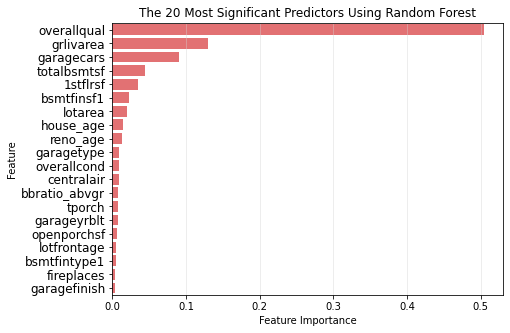

In [109]:
feature_importance = randomForest.feature_importances_
rf_feature_importances = pd.Series(feature_importance, index=X_train.columns.values).sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=rf_feature_importances,y=rf_feature_importances.index, color = '#F55E61');
ax.set_title('The 20 Most Significant Predictors Using Random Forest');
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.yticks(fontsize=12);
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)

# rf_feature_importances.index.tolist


## Random Forest Model #2

Removing features to improve model

In [110]:
#Reduced features, keeping the features with higher coefficients as this is a proxy of feature importance
features2 = (['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', '1stflrsf',
       'bsmtfinsf1', 'lotarea', 'house_age', 'reno_age', 'garagetype',
       'overallcond', 'centralair', 'bbratio_abvgr', 'tporch', 'garageyrblt',
       'openporchsf', 'lotfrontage', 'bsmtfintype1', 'fireplaces',
       'garagefinish'])

In [111]:
# Revised feature variable
X_feature2 = merged2[features2]

In [112]:
# Setting train and test sets
import numpy as np
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_feature2, target, test_size=0.33, random_state=0)

In [113]:
# Fitting Random Forest Regressor model on revised features
from sklearn import ensemble
randomForest2 = ensemble.RandomForestRegressor()

randomForest2.set_params(random_state=0)

randomForest2.fit(X_train2, y_train2) 

print("The training error is: %.5f" % (1 - randomForest2.score(X_train2, y_train2)))
print("The test     error is: %.5f" % (1 - randomForest2.score(X_test2, y_test2)))

The training error is: 0.01525
The test     error is: 0.10501


In [114]:
# Removing max_features this time as we want the model to select the number of features 
grid_para_forest2 = {
    'criterion': ['mse'],
    'max_depth': range(5, 26, 5),
    'n_estimators': [300, 600],
}

In [115]:
from sklearn.model_selection import GridSearchCV
grid_search_forest2 = GridSearchCV(randomForest2, grid_para_forest2, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
%time grid_search_forest2.fit(X_train2, y_train2)

Wall time: 48.7 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': range(5, 26, 5),
                         'n_estimators': [300, 600]},
             scoring='neg_mean_squared_error')

In [116]:
grid_search_forest2.best_params_

{'criterion': 'mse', 'max_depth': 15, 'n_estimators': 600}

In [117]:
grid_search_forest2.best_score_

-0.002866159475335262

In [118]:
print("The training R2 is: %.5f" % (grid_search_forest2.best_estimator_.score(X_train2, y_train2)))
print("The test R2 is: %.5f" % (grid_search_forest2.best_estimator_.score(X_test2, y_test2)))

The training R2 is: 0.98474
The test R2 is: 0.89591


We deem the new test R2 of 0.89591 to be better than model #1 as we were able to reduce the number of features to 15
from 20, hence creating a simpler model. However, there still is overfitting as evidenced by the gap between the train R2 of 0.98474. 

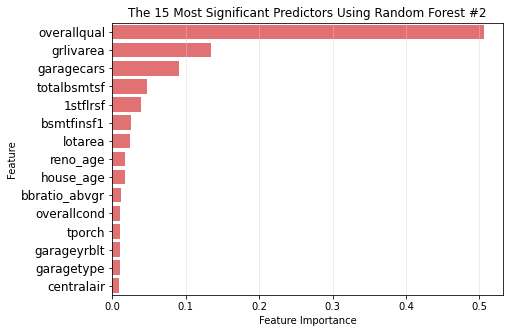

In [121]:
feature_importance2 = randomForest2.feature_importances_
rf_feature_importances = pd.Series(feature_importance2, index=X_train2.columns.values).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=rf_feature_importances,y=rf_feature_importances.index, color = '#F55E61');
ax.set_title('The 15 Most Significant Predictors Using Random Forest #2');
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.yticks(fontsize=12);
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)

# rf_feature_importances.tolist